In [21]:
# 📦 导入依赖
import ROOT
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.special import lambertw
import pandas as pd
import pickle
import os
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
plot_dir = "/home/llr/ilc/shi/code/Energy-Reco/Figures"
fig_size = (8, 6)

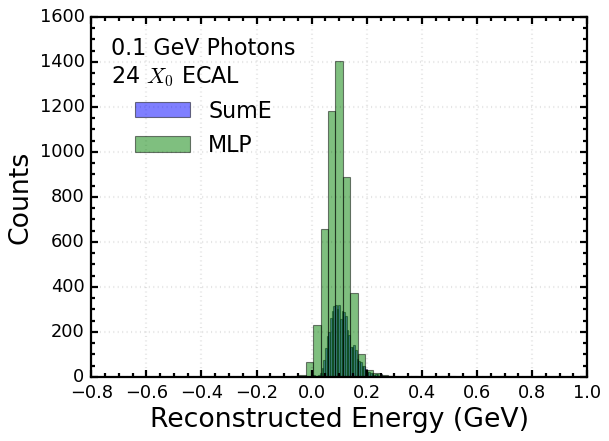

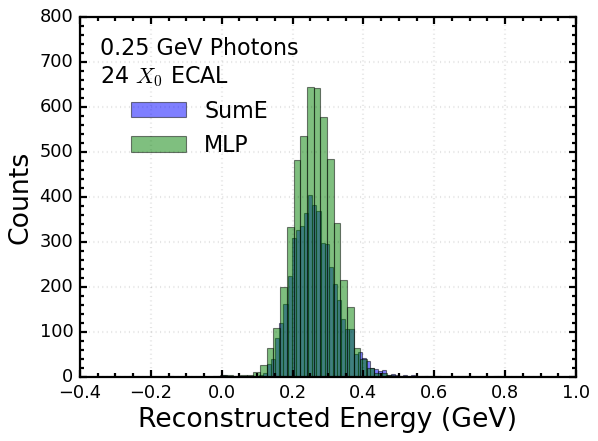

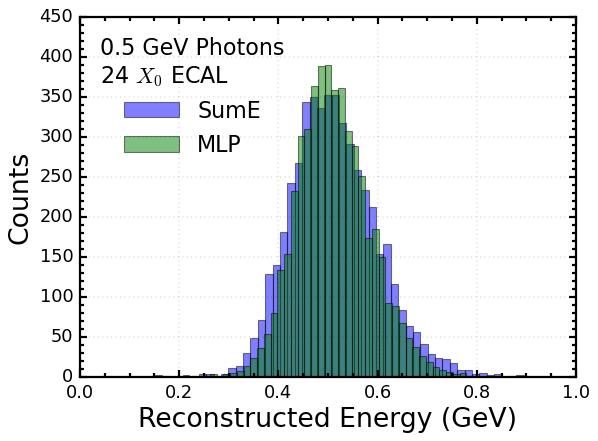

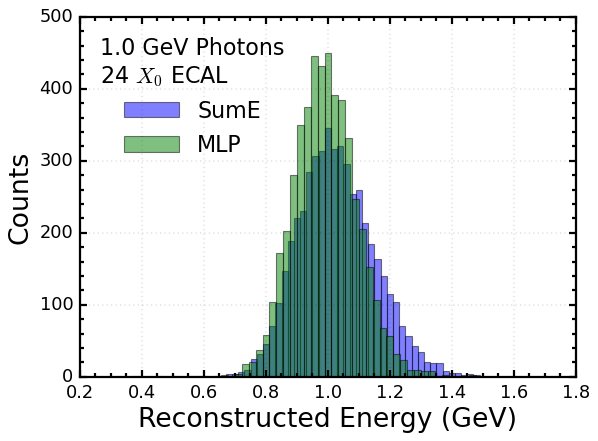

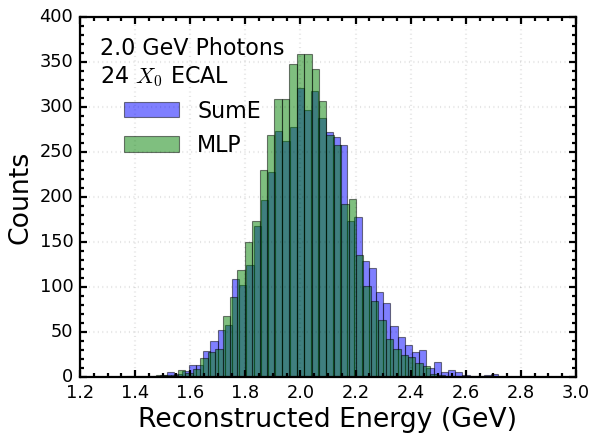

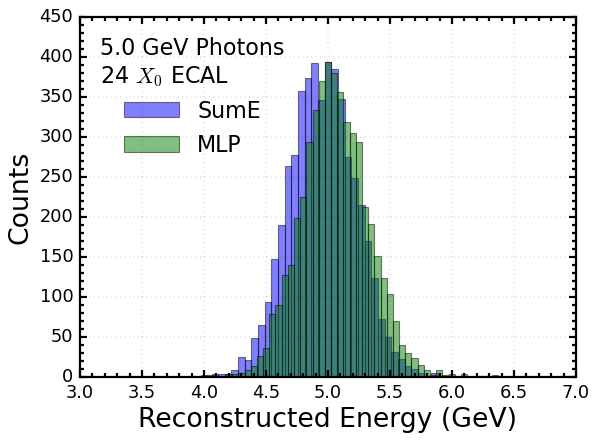

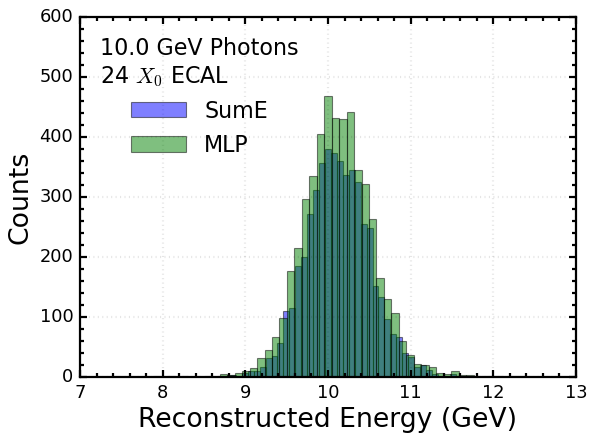

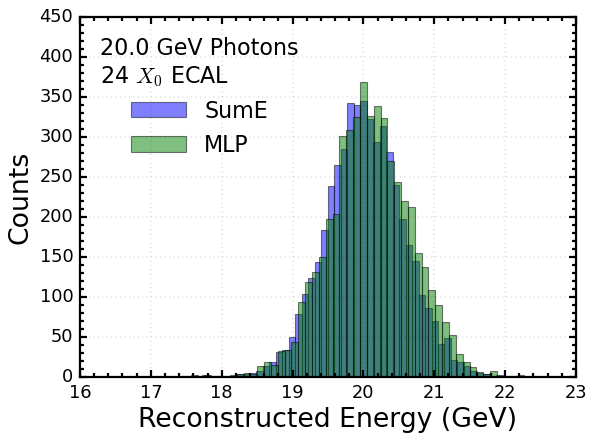

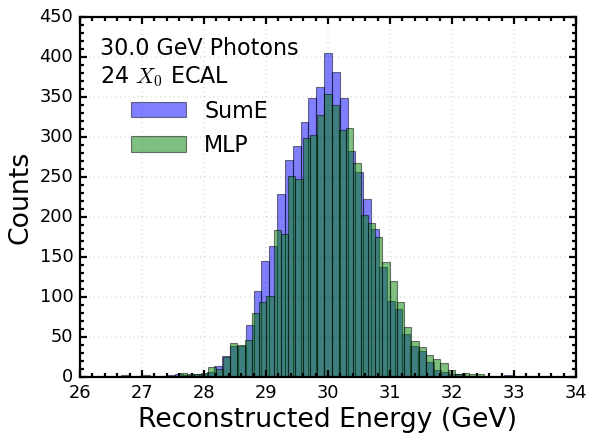

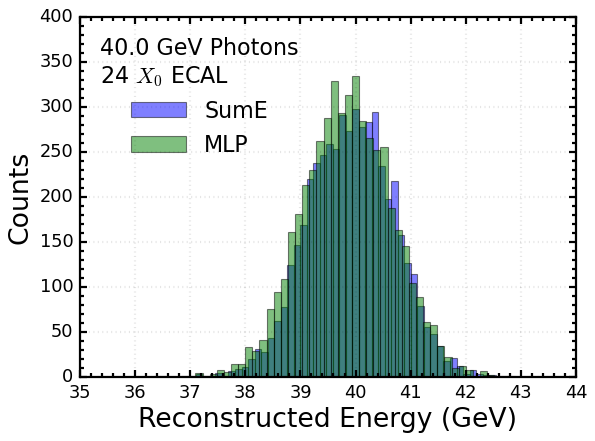

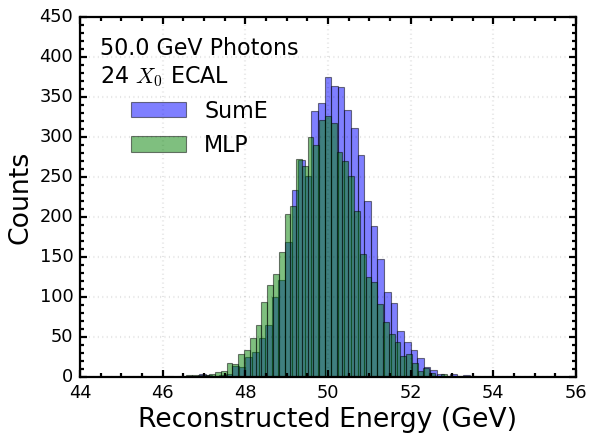

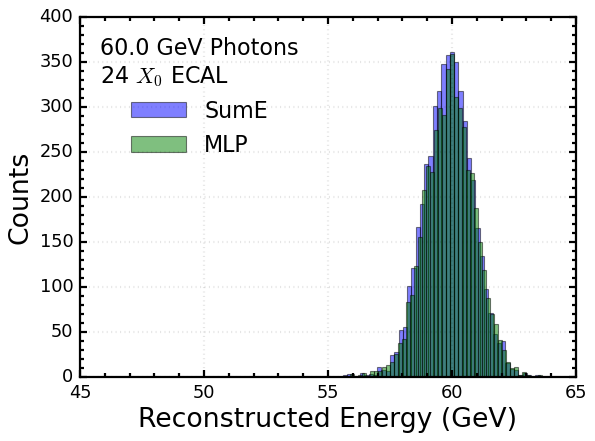

In [26]:
def ConstructHists(E_reco,Nbins=50):
    mean = np.mean(E_reco)
    rms = np.std(E_reco)
    mask = (E_reco >= mean - 5*rms) & (E_reco <= mean + 5*rms)
    filtered_data = E_reco[mask]
    counts, bin_edges = np.histogram(filtered_data, bins=Nbins)
    return counts, bin_edges
# 打开 ROOT 文件，载入 events tree
MIP_table={# Si thickness (mm) : MIP (MeV)
    0.15:0.0410,
    0.3:0.0861,
    0.45:0.1328,
    0.6:0.1803,
    0.75:0.2282
}
Threshold_i=0.1
Si=0.75  # mm
SamplingLayer=60
ECAL_layers=120
radiation_length= ECAL_layers*24/120
CellSize=5.0  # mm
Threshold=Threshold_i*MIP_table[Si]
DataPath=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X{CellSize:.1f}mm_Y{CellSize:.1f}mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}"
ParticleEnergy=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)
CONF=("SumE","MLP")
hist_dict = {
    conf: pickle.load(open(f"{DataPath}/Hist/{conf}_Hists.pkl", "rb"))
    for conf in CONF
}

for conf in CONF:
    energies = [hist['Energy'] for hist in hist_dict[conf]]
    for i, (e_base, e_conf) in enumerate(zip(ParticleEnergy, energies)):
        if e_base != e_conf:
            print(f"Mismatch at index {i}: {conf}={e_conf}, ParticleEnergy={e_base}")

for i, E in enumerate(ParticleEnergy):
    plt.figure(figsize=fig_size)
    
    for conf in CONF:
        hist = hist_dict[conf][i]

        counts = hist['counts']
        bin_edges = hist['bin_edges']
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # 找峰值位置
        peak_index = np.argmax(counts)
        peak_x = bin_centers[peak_index]

        # x 方向缩放比例，使峰值对齐到 E
        scale = E / peak_x if peak_x != 0 else 1.0
        bin_centers_scaled = bin_centers * scale

        plt.bar(bin_centers_scaled, counts,
                width=(bin_edges[1]-bin_edges[0])*scale,
                alpha=0.5, label=f'{conf}', align='center')

    plt.xlabel('Reconstructed Energy (GeV)')
    plt.ylabel('Counts')
    #plt.title(rf'$E_{{\rm reco}}$ of {E} GeV Photons')
    plt.legend(title=f'{E} GeV Photons\n{radiation_length:.0f} $X_0$ ECAL', loc='upper left', title_fontsize=20)
    plt.grid(True)
    if i == len(ParticleEnergy) - 1:
        plt.xlim(45, 65)
        plt.savefig(f"{plot_dir}/Hist_leakage_{radiation_length:.0f}X0.pdf",dpi=300,bbox_inches='tight')
    plt.show()


